# The idea is to teach a model to see
# the difference between cores
# And make a verdict what a core type was given
# The types are < EVEN, INTERMEDIATE, HIGH INTENSIVE >

In [1091]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display

In [1092]:
df = pd.read_excel("input.xlsx", sheet_name="no_burnup")
# df2 = pd.read_excel("input_classification_extra_data.xlsx")

In [1093]:
df.columns

Index(['Name', 'pmar', 'p, %', 'p, beff', '7-6_s', '7-5_s', '7-4_s', '7-3_s',
       '6-6_s', '6-5_s', '6-4_s', '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s',
       '3-6_s', '3-5_s', '3-4_s', '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s',
       '7-6_b', '7-5_b', '7-4_b', '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b',
       '5-6_b', '5-3_b', '4-6_b', '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b',
       '2-6_b', '2-5_b', '2-4_b', '2-3_b', '7-6_t', '7-5_t', '7-4_t', '7-3_t',
       '6-6_t', '6-5_t', '6-4_t', '6-3_t', '5-6_t', '5-3_t', '4-6_t', '4-3_t',
       '3-6_t', '3-5_t', '3-4_t', '3-3_t', '2-6_t', '2-5_t', '2-4_t', '2-3_t',
       'Temperature, K', 'p loss due to temperature, %', 'Notes'],
      dtype='object')

In [1094]:
d1 = display.Display(df=df)
# d2 = display.Display(df=df2)
d1.quick_processing()
# d2.quick_processing()

The columns with prefix  are not in DataFrame


In [1095]:
# cols = [
#     "Name",
#     *d1.CORE_PARTS["coef"]["ALL_CELLS"],
#     *d1.CORE_PARTS["burnup"]["ALL_CELLS"],
#     "right_side_s", "left_side_s", "center_s",
#     "right_side", "left_side", "center",
#     "average", "p, %"
# ]
# df = pd.concat(
#     [d1.df.loc[:, cols], d2.df.loc[:, cols]],
#     axis=0
# ).reset_index().drop(0, axis=1, errors="ignore")

In [1096]:
from itertools import permutations

In [1097]:
# global condition
# the fuel burnup should be distributed by layers as follows
# 0 - left < center < right (LCR)
# 1 - right < center < left (RCL)
# 2 - center < right < left (CRL)
# 3 - center < left < right (CLR)
# 4 - right < left < center (RLC)
# 5 - left < right < center (LRC)





In [1098]:
# gc_0 = (df["left_side_s"] > df["center_s"])\
#         & (df["left_side_s"] > df["right_side_s"])

# gc_1 = (df["left_side_s"] < df["right_side_s"])\
#         & (df["center_s"] < df["right_side_s"])

# gc_2 = (df["right_side_s"] < df["center_s"])\
#         & (df["left_side_s"] < df["center_s"])

# df["skewness_side"] = np.where(
#     gc_0,
#     "L",
#     np.where(
#         gc_1,
#         "R",
#         np.where(
#             gc_2,
#             "CENTERED",
#             "Others"
#         )
#     )
# )
# sk = np.absolute(df["left_side_s"] / df["right_side_s"] - 1)

In [1099]:
gc_0 = (df["left_center_side_s"] > df["right_center_side_s"])

gc_1 = (df["left_center_side_s"] < df["right_center_side_s"])

df["skewness_side"] = np.where(
    gc_0,
    "L",
    np.where(
        gc_1,
        "R",
        "Others"
    )
)
sk = np.absolute(df["left_center_side_s"] / df["right_center_side_s"] - 1)

In [1100]:
sk_0 = sk > 0.15
sk_1 = (sk <= 0.15) & (sk > 0.05)
sk_2 = sk <= 0.05

In [1101]:
df["skewnewss"] = np.where(
    sk_0,
    "PERM_REQUIRED",
    np.where(
        sk_1,
        "PERM_RECOMMENDED",
        np.where(
            sk_2,
            "UNIFORM_CORE",
            None
        )
    )
)

In [1102]:
df["skewness_side"].value_counts()

skewness_side
R    161
L     21
Name: count, dtype: int64

In [1103]:
df["skewnewss"].value_counts()

skewnewss
PERM_REQUIRED       84
PERM_RECOMMENDED    67
UNIFORM_CORE        31
Name: count, dtype: int64

In [1104]:
uniform = df[df["skewnewss"] == "UNIFORM_CORE"]
skewed = df[(df["skewnewss"] == "PERM_REQUIRED") | (df["skewnewss"] == "PERM_RECOMMENDED")]

In [1105]:
d1.display(skewed.iloc[7], dt="_s")

,6,5,4,3
7,0.928946,1.137616,0.711553,0.746304
6,0.868008,1.003537,1.333576,1.208032
5,0.831211,nan,nan,1.278721
4,1.142771,nan,nan,1.560097
3,0.805478,1.181592,0.991552,1.163962
2,0.726466,0.706018,0.838328,0.836233


In [1106]:
uniform["right_center_side_s"].mean(), uniform["left_center_side_s"].mean(), skewed["right_center_side_s"].mean(), skewed["left_center_side_s"].mean(), 

(1.0046058170631564,
 0.9953941829368435,
 1.0820753182880676,
 0.9179246817119324)

# Auto labeling of RIGHT SKEWED CORE
## Set 2 cells only to permutate
## Generates N number of new cores. N depends on nubmer of avaliable cells (6 is maximum)
## So each cell from right sequantially replace one from left (6 replacement is maximum)
## The maximum number of new cores is 12

In [1109]:
from joblib import load
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [1110]:
reg_model = load("stck_bag_non_unifor_v1.2.joblib")

In [1111]:
def validation_stacking_bagging(
    models:dict,
    X_val_raw,
    y_val = None,
    averaging:bool = False
):
    res_dict = defaultdict(list)

    for key, model in models.items():
        # res_dict[key] = defaultdict()
        for k, v in model.items():
    
            base = v["base"]
            X_val = base["ct_base"].transform(X_val_raw)
            X_val_base = X_val.copy()
            
        
            # print(X_val_raw)
            for kb, bvals in base["models"].items():
                if kb == "bagging" and len(bvals) > 0:
                    for bag_names, bag_mods in base["models"].get("bagging").items():
                        for bnum, bag_mod in enumerate(bag_mods):
                            X_val_base.loc[:, [f"{bag_names}_{bnum}"]] = bag_mod.predict(X_val)
                
                elif kb != "bagging":
                    X_val_base.loc[:, kb] = bvals.predict(X_val)
                
            X_meta = X_val_base

            # X_meta = X_meta.loc[
            #     :,
            #     list(set(X_meta).difference(set(X_val)))
            # ]
            
            X_meta = X_meta.reindex(sorted(X_meta), axis=1)

            res_dict[k].append( v["meta"].predict(X_meta) )
    
    res_arr = np.array(list(res_dict.values())).mean(axis=1)
    
    res = pd.DataFrame(data=res_arr).T
    res.columns = res_dict.keys()
    # print(res_dict)
    # print(res)
    if y_val is not None:
        print(mean_absolute_error(
            res,
            y_val
        ))
    return res


In [1225]:
type(df)

pandas.core.frame.DataFrame

In [1112]:
from main.permutations import Permutations

In [1113]:
# skewed = skewed.loc[:,
#      [
#          "Name",
#          *d1.CORE_PARTS["coef"]["ALL_CELLS"],
#          *d1.CORE_PARTS["burnup"]["ALL_CELLS"],
#          *d1.CORE_PARTS["left"]["ALL_CELLS"],
#          *d1.CORE_PARTS["fuel_type"]["ALL_CELLS"],
         
#      ]
# ] 

In [1114]:
# candidates from right
all_right_center = d1.CORE_PARTS["default"]["RIGHT_CENTER_SIDE"]
all_left_center = d1.CORE_PARTS["default"]["LEFT_CENTER_SIDE"]



In [1117]:
aug_dfs = []
burn_diffs = list(map(lambda x: f"{x}_d", p.CORE_PARTS["burnup"]["ALL_CELLS"]))
burn_old = list(map(lambda x: f"{x}_old", p.CORE_PARTS["burnup"]["ALL_CELLS"]))  
burn_rcs_old = list(map(lambda x: f"{x}_old", p.CORE_PARTS["burnup"]["RIGHT_CENTER_SIDE"]))  

nonunif_old = list(map(lambda x: f"{x}_old", p.CORE_PARTS["coef"]["ALL_CELLS"]))  
nonunif_rcs_old = list(map(lambda x: f"{x}_old", p.CORE_PARTS["coef"]["RIGHT_CENTER_SIDE"]))  


for ind in skewed.index:
    p = Permutations(df=skewed, ind=ind)
    stressed = p._cells_to_permutate_finder()[:3]
    print(stressed)
    for i in stressed:
        
        
        pp, from_, to_ = p.single_cell_pairwise_permutations(i, pairwise_exceptions=all_right_center, make=True, indep_chain=True, merge=True)
        pp_predictions = validation_stacking_bagging(reg_model, pp)

        pp = pd.concat([pp, pp_predictions], axis=1)        
        pp["rel_non_unif_change"] = pp_predictions\
            .loc[:, d1.CORE_PARTS["coef"]["RIGHT_CENTER_SIDE"]].mean(axis=1) / p.df.loc[ind, "right_center_side_s"]
        pp["sub_non_unif_change"] = -pp_predictions\
            .loc[:, d1.CORE_PARTS["coef"]["RIGHT_CENTER_SIDE"]].mean(axis=1) + p.df.loc[ind, "right_center_side_s"]
        pp[burn_diffs] = pp.loc[:, p.CORE_PARTS["burnup"]["ALL_CELLS"]].values - p.df.loc[:, p.CORE_PARTS["burnup"]["ALL_CELLS"]].values
        
        for n, j in enumerate(pp.index):
            pp.loc[n, "from_"] = p.df.loc[:, f"{from_[n]}_b"].values
            pp.loc[n, "to_"] = p.df.loc[:, f"{to_[n]}_b"].values
            pp.loc[
                n, 
                burn_old
            ] = p.df.loc[:, p.CORE_PARTS["burnup"]["ALL_CELLS"]].values
            pp.loc[
                n, 
                nonunif_old
            ] = p.df.loc[:, p.CORE_PARTS["coef"]["ALL_CELLS"]].values

        
        # pp = pp.loc[
        #     :,
        #     [
        #         *p.CORE_PARTS["burnup"]["ALL_CELLS"],
        #         *burn_diffs,
        #         *burn_old,
        #         "non_unif_change",
        #         "from_",
        #         "to_"
        #     ]
        # ]
        print(pp)
        aug_dfs.append(pp)
aug_df = pd.concat(aug_dfs, axis=0).reset_index().drop("index", axis=1)

Index(['Name', 'pmar', 'p, %', 'p, beff', '7-6_s', '7-5_s', '7-4_s', '7-3_s',
       '6-6_s', '6-5_s',
       ...
       'left_center_side_t', 'right_side_t', 'left_side_t', 'center_t',
       'qul_t', 'qur_t', 'qll_t', 'qlr_t', 'skewness_side', 'skewnewss'],
      dtype='object', length=159)
['5-3' '7-6' '2-5']
Detected among six tubes [] Detected among eight tubes ['2-6', '7-6', '2-5', '7-5', '5-3', '4-6']
  Name     pmar      p, %   p, beff  7-6_b   7-5_b    7-4_b  7-3_b  6-6_b  \
0  112  1.07861  7.297184  9.295775  45.99  144.21  71.7355  80.52  75.79   
1  112  1.07861  7.297184  9.295775   0.00   45.99  71.7355  80.52  75.79   
2  112  1.07861  7.297184  9.295775   0.00  144.21  71.7355  80.52  75.79   
3  112  1.07861  7.297184  9.295775   0.00  144.21  71.7355  80.52  75.79   
4  112  1.07861  7.297184  9.295775   0.00  144.21  71.7355  80.52  75.79   

     6-5_b  ...  4-6_s_old  4-3_s_old  3-6_s_old  3-5_s_old  3-4_s_old  \
0  63.7855  ...   0.998171   1.225385   0.887513   

In [1118]:
aug_df

,Name,pmar,"p, %","p, beff",7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,...,4-6_s_old,4-3_s_old,3-6_s_old,3-5_s_old,3-4_s_old,3-3_s_old,2-6_s_old,2-5_s_old,2-4_s_old,2-3_s_old
0,112,1.07861,7.297184,9.295775,45.99,144.21,71.7355,80.52,75.790,63.7855,...,0.998171,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869
1,112,1.07861,7.297184,9.295775,0.00,45.99,71.7355,80.52,75.790,63.7855,...,0.998171,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869
2,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,0.998171,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869
3,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,0.998171,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869
4,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,0.998171,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,127_fake_burn2_e2,1.04211,4.261140,5.428204,46.05,135.45,55.2900,157.65,97.997,163.7170,...,0.834223,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866
1823,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,46.05,55.2900,135.45,97.997,163.7170,...,0.834223,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866
1824,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,135.45,55.2900,132.33,97.997,163.7170,...,0.834223,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866
1825,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,135.45,55.2900,151.53,97.997,163.7170,...,0.834223,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866


In [1119]:
aug_df.to_excel("skeweness_fix_augmented_4.1.xlsx")

In [1207]:
aug_df = pd.read_excel("skeweness_fix_augmented_4.1.xlsx", index_col=0)

In [1208]:
aug_df["right_center_side_s_old"] = aug_df.loc[:, nonunif_rcs_old].mean(axis=1)

## From the plot below i can conclude that some predictions made by model are not correct that is why there a lot of points near 1.00 

In [1209]:
aug_df["sub_non_unif_change"], aug_df["rel_non_unif_change"]

(0      -0.019059
 1       0.041061
 2       0.022170
 3       0.046803
 4      -0.015069
           ...   
 1822    0.039997
 1823    0.026218
 1824    0.035821
 1825    0.040160
 1826    0.025890
 Name: sub_non_unif_change, Length: 1827, dtype: float64,
 0       1.017609
 1       0.962062
 2       0.979516
 3       0.956756
 4       1.013923
           ...   
 1822    0.967014
 1823    0.978378
 1824    0.970458
 1825    0.966880
 1826    0.978648
 Name: rel_non_unif_change, Length: 1827, dtype: float64)

<Axes: xlabel='sub_non_unif_change', ylabel='Count'>

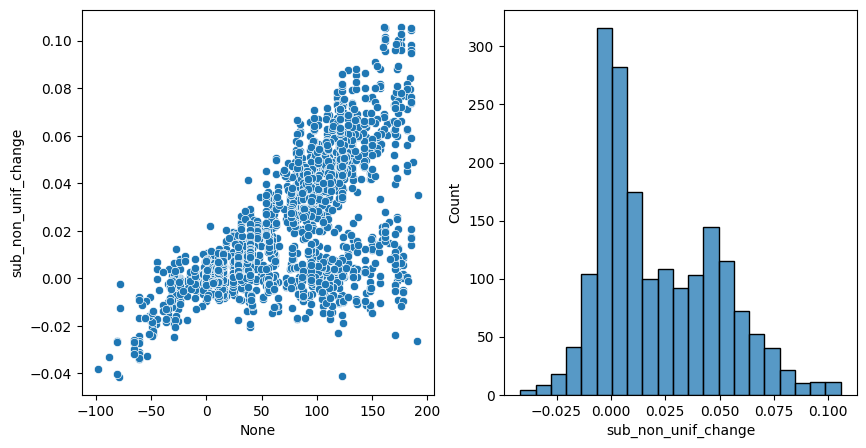

In [1210]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x=aug_df["to_"] - aug_df["from_"], y=aug_df["sub_non_unif_change"], ax=axs[0])
sns.histplot(aug_df["sub_non_unif_change"], ax=axs[1])

### Drop some points in range of 0.995-1.005 (-0.005-0.005)

In [1211]:
# frac_drop =  aug_df[
#     (aug_df["sub_non_unif_change"] > -0.01) 
#     & (aug_df["sub_non_unif_change"] < 0.01)
# ].sample(frac=0.7).index
# aug_df = aug_df.drop(index=frac_drop)
# aug_df = aug_df.reset_index().drop("index", axis=1)

In [1212]:
aug_df

,Name,pmar,"p, %","p, beff",7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,...,4-3_s_old,3-6_s_old,3-5_s_old,3-4_s_old,3-3_s_old,2-6_s_old,2-5_s_old,2-4_s_old,2-3_s_old,right_center_side_s_old
0,112,1.07861,7.297184,9.295775,45.99,144.21,71.7355,80.52,75.790,63.7855,...,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869,1.082313
1,112,1.07861,7.297184,9.295775,0.00,45.99,71.7355,80.52,75.790,63.7855,...,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869,1.082313
2,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869,1.082313
3,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869,1.082313
4,112,1.07861,7.297184,9.295775,0.00,144.21,71.7355,80.52,75.790,63.7855,...,1.225385,0.887513,0.759753,1.137373,1.230191,0.644860,1.030717,0.609676,0.906869,1.082313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,127_fake_burn2_e2,1.04211,4.261140,5.428204,46.05,135.45,55.2900,157.65,97.997,163.7170,...,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866,1.212547
1823,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,46.05,55.2900,135.45,97.997,163.7170,...,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866,1.212547
1824,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,135.45,55.2900,132.33,97.997,163.7170,...,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866,1.212547
1825,127_fake_burn2_e2,1.04211,4.261140,5.428204,157.65,135.45,55.2900,151.53,97.997,163.7170,...,1.610410,0.804277,1.007227,0.780856,1.198926,0.645989,0.777245,1.063803,1.150866,1.212547


<Axes: xlabel='sub_non_unif_change', ylabel='Count'>

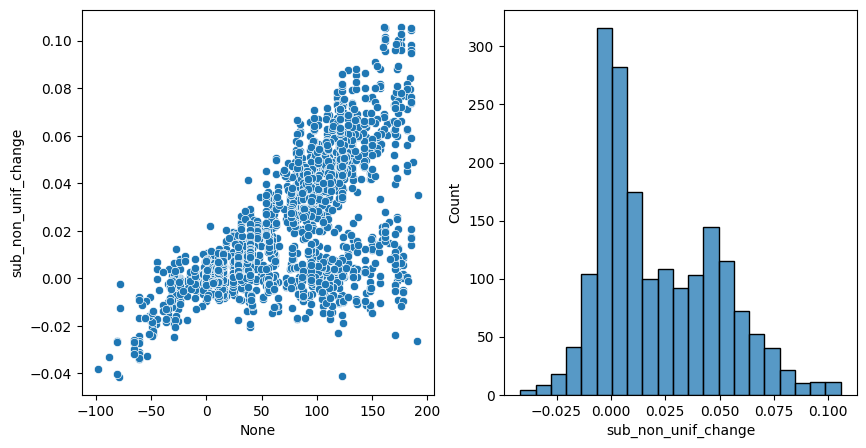

In [1213]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x=aug_df["to_"] - aug_df["from_"], y=aug_df["sub_non_unif_change"], ax=axs[0])
sns.histplot(aug_df["sub_non_unif_change"], ax=axs[1])

In [1214]:
# bins = pd.IntervalIndex.from_tuples(
#     [
#         (-0.1, 0),
#         (0, 0.01),
#         (0.01, 0.03),
#         (0.03, 0.05),
#         (0.05, 0.07),
#         (0.07, 0.1),
#     ]
# )
# aug_df["non_unif_change_binned"], i = pd.cut(aug_df["non_unif_change"], bins=6, labels=["0","1","2","3","4","5"], retbins=True)
aug_df["sub_non_unif_change_binned"] =  np.where(
    (aug_df["sub_non_unif_change"] <= 0.015),
    "0",
    np.where(
        (aug_df["sub_non_unif_change"] > 0.015) & (aug_df["sub_non_unif_change"] <= 0.06),
        "1",
        np.where(
            (aug_df["sub_non_unif_change"] > 0.06),
            "2",
            None
        )
    )
)

In [1215]:
# aug_df["sub_non_unif_change_binned"] =  np.where(
#     (aug_df["sub_non_unif_change"] <= 0),
#     "0",
#     np.where(
#         (aug_df["sub_non_unif_change"] > 0),
#         "1",
#         None
#     )
# )

In [1216]:
aug_df = aug_df.drop("sub_non_unif_change", axis=1) 

In [1217]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, ShuffleSplit

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [1218]:
aug_df_selec = aug_df.loc[
    :,
    [
        *d1.CORE_PARTS["burnup"]["ALL_CELLS"],
        *burn_diffs,
        "right_center_side_s_old",
        "sub_non_unif_change_binned",
        # "from_",
        # "to_"
    ]
]

In [1219]:
y = aug_df_selec["sub_non_unif_change_binned"]
X_raw = aug_df_selec.drop(["sub_non_unif_change_binned"], axis=1)
X_raw, y

(       7-6_b   7-5_b    7-4_b   7-3_b   6-6_b     6-5_b    6-4_b    6-3_b  \
 0      45.99  144.21  71.7355   80.52  75.790   63.7855  155.714  19.4510   
 1       0.00   45.99  71.7355   80.52  75.790   63.7855  155.714  19.4510   
 2       0.00  144.21  71.7355   80.52  75.790   63.7855  155.714  19.4510   
 3       0.00  144.21  71.7355   80.52  75.790   63.7855  155.714  19.4510   
 4       0.00  144.21  71.7355   80.52  75.790   63.7855  155.714  19.4510   
 ...      ...     ...      ...     ...     ...       ...      ...      ...   
 1822   46.05  135.45  55.2900  157.65  97.997  163.7170  100.594  85.1445   
 1823  157.65   46.05  55.2900  135.45  97.997  163.7170  100.594  85.1445   
 1824  157.65  135.45  55.2900  132.33  97.997  163.7170  100.594  85.1445   
 1825  157.65  135.45  55.2900  151.53  97.997  163.7170  100.594  85.1445   
 1826  157.65  135.45  55.2900  133.80  97.997  163.7170  100.594  85.1445   
 
          5-6_b   5-3_b  ...  4-3_b_d  3-6_b_d  3-5_b_d  3-4_b

In [1220]:
ct = ColumnTransformer(
     [
         # ("", StandardScaler(), X_raw.columns)
         ("", PowerTransformer(), X_raw.columns)
     ]
).set_output(transform="pandas")

In [1221]:
X = ct.fit_transform(X_raw)

In [1222]:
ss = list(ShuffleSplit(n_splits=5, random_state=42).split(X, y))

In [1223]:
m1 = RandomForestClassifier()
gbc = GradientBoostingClassifier(n_estimators=200, max_depth=5)
m3 = MLPClassifier(hidden_layer_sizes=512)

In [1224]:
for tr, te in ss:
    m1.fit(X.loc[tr, :], y.loc[tr])
    gbc.fit(X.loc[tr, :], y.loc[tr])
    m3.fit(X.loc[tr, :], y.loc[tr])
    
    y_pred_m1 = m1.predict(X.loc[te, :])
    y_pred_gbc = gbc.predict(X.loc[te, :])
    y_pred_m3 = m3.predict(X.loc[te, :])

    print(
        accuracy_score(y.loc[te], y_pred_m1), 
        accuracy_score(y.loc[te], y_pred_gbc), 
        accuracy_score(y.loc[te], y_pred_m3)
    )
    print(confusion_matrix(y.loc[te], y_pred_m1, normalize="true"), end="\n")
    print(confusion_matrix(y.loc[te], y_pred_gbc, normalize="true"), end="\n")
    print(confusion_matrix(y.loc[te], y_pred_m3, normalize="true"), end="\n")



/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9234972677595629 0.9016393442622951 0.8961748633879781
[[0.97959184 0.02040816 0.        ]
 [0.04166667 0.875      0.08333333]
 [0.         0.23076923 0.76923077]]
[[0.95918367 0.04081633 0.        ]
 [0.05555556 0.84722222 0.09722222]
 [0.         0.23076923 0.76923077]]
[[0.94897959 0.05102041 0.        ]
 [0.06944444 0.83333333 0.09722222]
 [0.         0.15384615 0.84615385]]


/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9508196721311475 0.9508196721311475 0.9617486338797814
[[0.95918367 0.04081633 0.        ]
 [0.02985075 0.97014925 0.        ]
 [0.         0.16666667 0.83333333]]
[[0.93877551 0.06122449 0.        ]
 [0.01492537 0.98507463 0.        ]
 [0.         0.11111111 0.88888889]]
[[0.96938776 0.03061224 0.        ]
 [0.02985075 0.95522388 0.01492537]
 [0.         0.05555556 0.94444444]]


/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.912568306010929 0.9016393442622951 0.907103825136612
[[0.94680851 0.05319149 0.        ]
 [0.10294118 0.89705882 0.        ]
 [0.         0.19047619 0.80952381]]
[[0.92553191 0.07446809 0.        ]
 [0.10294118 0.89705882 0.        ]
 [0.         0.19047619 0.80952381]]
[[0.94680851 0.05319149 0.        ]
 [0.11764706 0.88235294 0.        ]
 [0.         0.19047619 0.80952381]]


/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8907103825136612 0.8743169398907104 0.907103825136612
[[0.95555556 0.04444444 0.        ]
 [0.11594203 0.88405797 0.        ]
 [0.         0.33333333 0.66666667]]
[[0.94444444 0.05555556 0.        ]
 [0.13043478 0.85507246 0.01449275]
 [0.         0.33333333 0.66666667]]
[[0.98888889 0.01111111 0.        ]
 [0.10144928 0.88405797 0.01449275]
 [0.         0.33333333 0.66666667]]
0.9398907103825137 0.9289617486338798 0.912568306010929
[[0.99029126 0.00970874 0.        ]
 [0.07142857 0.85714286 0.07142857]
 [0.         0.         1.        ]]
[[0.96116505 0.03883495 0.        ]
 [0.07142857 0.87142857 0.05714286]
 [0.         0.         1.        ]]
[[0.97087379 0.02912621 0.        ]
 [0.07142857 0.84285714 0.08571429]
 [0.         0.2        0.8       ]]


/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
right_center_candidates = list(set(p.interchan_8th).intersection(set(all_right_center)))
left_center_candidates = list(set(p.interchan_8th).intersection(set(all_left_center)))
left_center_candidates

['7-6', '7-5', '2-5', '4-6']

In [22]:
right_center_candidates_s = list(map(lambda x: f"{x}_s", right_center_candidates))
right_center_candidates_b = list(map(lambda x: f"{x}_b", right_center_candidates))
right_center_candidates = (skewed.loc[15, right_center_candidates_s] * skewed.loc[15, right_center_candidates_b].to_numpy()).sort_values()

In [23]:
permutative =  right_center_candidates[:2].index

In [24]:
perm_0_arr = np.full((len(left_center_candidates) ,), "4-3")

In [25]:
perm_0_arr

array(['4-3', '4-3', '4-3', '4-3'], dtype='<U3')

In [23]:
res_perm = p.make_permutations(fr, to, indep_chain=True)

Detected among six tubes [] Detected among eight tubes ['4-6', '2-5', '4-3', '7-6', '7-5']


In [92]:
for n,i in enumerate(res_perm.copy()):
    res_perm[n] = pd.concat(
        [
            res_perm[n].reset_index().drop("index", axis=1), 
            validation_stacking_bagging(reg_model, i)
        ], 
        axis=1
    )
    res_perm[n]["from"] = p.df[f"{perm_0_arr[n]}_b"].values
    res_perm[n]["to"] = p.df[f"{left_center_candidates[n]}_b"].values


In [94]:
res_perm_all = pd.concat(res_perm, axis=0)

In [95]:
# chain permutation is not suitable
res_d = display.Display(df=res_perm_all)
res_d.quick_processing()

The columns with prefix  are not in DataFrame


In [107]:
#perdictable
res_d.df["change_right_center_side_s"] = res_d.df["right_center_side_s"] / df.loc[15, "right_center_side_s"]

In [108]:
inp = []
for i in range(4):
    df_ = skewed.loc[15:15, [
             *d1.CORE_PARTS["burnup"]["ALL_CELLS"],
             *d1.CORE_PARTS["left"]["ALL_CELLS"]
    ]]
    df_["to"] = res_d.df.iloc[i]["to"]
    df_["from"] = res_d.df.iloc[i]["from"]
    df_["change_right_center_side_s"] = res_d.df.iloc[i]["change_right_center_side_s"]
    inp.append(df_)
    print(res_d.df.iloc[i]["to"])


157.23
182.58
64.89
136.59


In [109]:
inp

[     7-6_b   7-5_b  7-4_b   7-3_b    6-6_b     6-5_b  6-4_b  6-3_b     5-6_b  \
 15  157.23  182.58  60.75  133.08  111.194  113.7115  49.29  74.73  146.1475   
 
      5-3_b  ...     3-5_l     3-4_l     3-3_l    2-6_l   2-5_l   2-4_l  \
 15  119.28  ...  221.6195  147.1015  196.2855  155.237  235.11  119.64   
 
      2-3_l      to   from  change_right_center_side_s  
 15  158.91  157.23  25.74                    0.928591  
 
 [1 rows x 43 columns],
      7-6_b   7-5_b  7-4_b   7-3_b    6-6_b     6-5_b  6-4_b  6-3_b     5-6_b  \
 15  157.23  182.58  60.75  133.08  111.194  113.7115  49.29  74.73  146.1475   
 
      5-3_b  ...     3-5_l     3-4_l     3-3_l    2-6_l   2-5_l   2-4_l  \
 15  119.28  ...  221.6195  147.1015  196.2855  155.237  235.11  119.64   
 
      2-3_l      to   from  change_right_center_side_s  
 15  158.91  182.58  25.74                    0.923471  
 
 [1 rows x 43 columns],
      7-6_b   7-5_b  7-4_b   7-3_b    6-6_b     6-5_b  6-4_b  6-3_b     5-6_b  \
 15  15

In [1770]:
to_refuel = [i[0] for i in to_permutate]
to_swap = [i[1] for i in to_permutate]
best_to_swap = [i[2] for i in to_permutate]

In [1771]:
df["perm_to_refuel"] = pd.Series(data=to_refuel, index=df.index)

In [1951]:
df_ml_to_refuel = df.loc[:,
    [
        # *d1.CORE_PARTS["coef"]["ALL_CELLS"],
        *d1.CORE_PARTS["burnup"]["ALL_CELLS"],
        "vsym",
        "average",
        "p, %",
        # "ref_required"
    ]
]

In [1971]:
from sklearn.preprocessing import MultiLabelBinarizer

In [1973]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["perm_to_refuel"])
X_raw = df_ml_to_refuel

In [1969]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import jaccard_score, hamming_loss, multilabel_confusion_matrix

In [1955]:
ml_ct = ColumnTransformer(
    [
        ("numerical", StandardScaler(), X_raw.columns),
        # ("numerical", StandardScaler(), X_raw.columns[:-1]),
        # ("ohe", OneHotEncoder(sparse=False), ["ref_required"])
    ]
).set_output(transform="pandas")

In [1956]:
X = ml_ct.fit_transform(X_raw)

In [1957]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1974]:
rfc = RandomForestClassifier().fit(X_train, y_train)
etc = ExtraTreeClassifier().fit(X_train, y_train)

In [1975]:
rfc.score(X_test, y_test), etc.score(X_test, y_test)

(0.4090909090909091, 0.4090909090909091)

In [1976]:
rfc_pred = rfc.predict(X_test)
etc_pred = etc.predict(X_test)


In [1977]:
rfc.feature_importances_, X_raw.columns

(array([0.02638667, 0.03280698, 0.0485078 , 0.03599358, 0.05483948,
        0.03114317, 0.03181192, 0.03709029, 0.03417717, 0.03078684,
        0.03645797, 0.02655387, 0.0495311 , 0.03948447, 0.03177069,
        0.04752717, 0.03777351, 0.03030102, 0.02608906, 0.05441614,
        0.06179402, 0.09882029, 0.09593679]),
 Index(['7-6', '7-5', '7-4', '7-3', '6-6', '6-5', '6-4', '6-3', '5-6', '5-3',
        '4-6', '4-3', '3-6', '3-5', '3-4', '3-3', '2-6', '2-5', '2-4', '2-3',
        'vsym', 'average', 'p, %'],
       dtype='object'))

In [1978]:
etc.feature_importances_, X_raw.columns

(array([0.0764666 , 0.00869476, 0.02173691, 0.01811409, 0.04009252,
        0.09819756, 0.00627955, 0.03622818, 0.01304214, 0.02521481,
        0.0512508 , 0.05450687, 0.03811204, 0.02681031, 0.02898254,
        0.05385657, 0.04637207, 0.0318808 , 0.04582125, 0.01072354,
        0.0946845 , 0.0524584 , 0.1204732 ]),
 Index(['7-6', '7-5', '7-4', '7-3', '6-6', '6-5', '6-4', '6-3', '5-6', '5-3',
        '4-6', '4-3', '3-6', '3-5', '3-4', '3-3', '2-6', '2-5', '2-4', '2-3',
        'vsym', 'average', 'p, %'],
       dtype='object'))

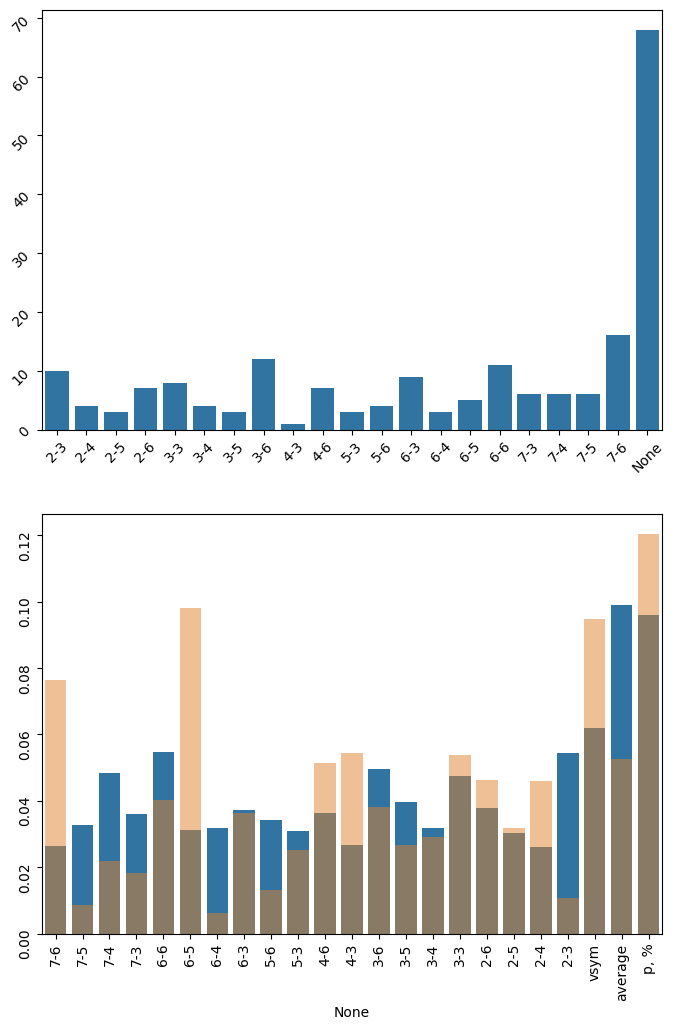

In [1979]:
fig, axs = plt.subplots(2,1, figsize=(8,12))
sns.barplot(y=sum(y), x=mlb.classes_, ax=axs[0])
sns.barplot(y=rfc.feature_importances_, x=X_raw.columns, ax=axs[1])
sns.barplot(y=etc.feature_importances_, x=X_raw.columns, ax=axs[1], alpha=0.5)

axs[0].tick_params(rotation=45)
axs[1].tick_params(rotation=90)

In [1987]:
best_3 = []
for i in rfc.predict_proba(X_test):
    print(i.shape)
    best_3.append( mlb.classes_[ np.argsort(i)[::-1][:3] ])
    

(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)
(22, 2)


In [1981]:
hamming_loss(rfc_pred, y_test), jaccard_score(rfc_pred, y_test, average="macro")

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.04329004329004329, 0.185515873015873)

In [1982]:
y_inversed = mlb.inverse_transform(y_test)
rfc_pred_inversed = mlb.inverse_transform(rfc_pred)
etc_pred_inversed = mlb.inverse_transform(etc_pred)

In [1983]:

ind = df.loc[55, :]
print(ind["Name"])
display.Display().display(ind)

123_3-3


,6,5,4,3
7,54.170000,12.020000,15.160000,25.110000
6,6.990000,35.130000,58.170000,63.560000
5,37.470000,nan,nan,45.070000
4,48.370000,nan,nan,44.650000
3,6.900000,53.580000,34.600000,0.000000
2,52.980000,17.040000,12.980000,24.220000


In [1984]:
for i in range(len(X_test)):
    print("<", X_test.index[i], ">", df.loc[X_test.index[i], "p, %"])
    print(y_inversed[i], rfc_pred_inversed[i], etc_pred_inversed[i]) #, best_3[i])

< 76 > 5.686160161253858
('4-6',) ('None',) ('None',)
< 10 > 7.943828506194586
('None',) ('None',) ('None',)
< 4 > 9.701049883671457
('None',) ('None',) ('None',)
< 99 > 5.880948589016217
('3-6',) () ('None',)
< 70 > 6.452827350899698
('4-6', '5-3', 'None') ('None',) ('5-3',)
< 66 > 5.713169906577342
('2-6', 'None') ('7-6', 'None') ('None',)
< 30 > 3.667374737928299
('2-3', '3-6', '6-6', '7-4') ('3-6', '6-6', '7-4') ('2-5', '3-6', '6-6', '7-4')
< 45 > 5.865492115350197
('3-3', '6-3', 'None') ('3-3', '6-3', 'None') ('3-3', '6-3', 'None')
< 94 > 5.42616383553653
('7-5', 'None') ('None',) ('3-4', '4-6', '5-6', '6-5')
< 11 > 6.714115003505491
('2-4', 'None') ('None',) ('3-5',)
< 78 > 7.591235842125187
('None',) ('None',) ('None',)
< 47 > 4.723368356845133
('3-3', '6-3') ('3-3', '6-3') ('3-3', '6-3')
< 0 > 7.297183737402775
('None',) ('None',) ('None',)
< 79 > 8.122354684947604
('None',) ('None',) ('None',)
< 18 > 5.843312773653873
('6-5',) ('7-6',) ('6-6',)
< 105 > 6.219752990729416
('7-4'